## Kaggle Poker Rules Induction
Let's start off with a few standard imports

In [4]:
import numpy as np
import pandas as pd

np.random.seed(198)

Now we can read our data into pandas dataframes

In [5]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

Visualizing data

In [6]:
#train_df

Splitting into training and validation sets

In [7]:
train, valid = train_df[5000:], train_df[:5000]
train_values = train.drop('hand', axis=1)
train_labels = train['hand']
valid_values = valid.drop('hand', axis=1)
valid_labels = valid['hand']

Decision-tree predictions using raw data

In [8]:
import sklearn.tree
clf = sklearn.tree.DecisionTreeClassifier()
clf.fit(train_values, train_labels)
pred = clf.predict(valid_values)
print(np.average(valid_labels == pred))

0.4658


Assuming that order doesn't matter - give each card a unique value

In [9]:
train_df['Card1'] = (train_df['S1']-1) * 13 + (train_df['C1']) - 1
train_df['Card2'] = (train_df['S2']-1) * 13 + (train_df['C2']) - 1
train_df['Card3'] = (train_df['S3']-1) * 13 + (train_df['C3']) - 1
train_df['Card4'] = (train_df['S4']-1) * 13 + (train_df['C4']) - 1
train_df['Card5'] = (train_df['S5']-1) * 13 + (train_df['C5']) - 1
card_list = ['Card1','Card2','Card3','Card4','Card5']
card_df = train_df[card_list]

In [10]:
#card_df

Combine the Groups

In [11]:
card_df = pd.get_dummies(card_df, prefix='Card', columns=card_list)
card_df = card_df.groupby(card_df.columns, axis=1).sum()

In [12]:
#card_df

In [13]:
train_values, valid_values = card_df[5000:], card_df[:5000]

Training a decision tree on new data

In [14]:
import sklearn.ensemble
clf = sklearn.tree.DecisionTreeClassifier()
clf.fit(train_values, train_labels)
pred = clf.predict(valid_values)
print(np.average(valid_labels == pred))

0.6426


Better, but what about an ensemble method?

In [15]:
clf = sklearn.ensemble.RandomForestClassifier(n_estimators=10)
clf.fit(train_values, train_labels)
pred = clf.predict(valid_values)
print(np.average(valid_labels == pred))

0.7358


What's the optimal number of trees?

number of trees: 1, time to train: 0.347851, accuracy: 0.582200
number of trees: 2, time to train: 0.073792, accuracy: 0.627000
number of trees: 4, time to train: 0.170200, accuracy: 0.668600
number of trees: 8, time to train: 0.304869, accuracy: 0.724600
number of trees: 16, time to train: 0.606178, accuracy: 0.772200
number of trees: 32, time to train: 1.370654, accuracy: 0.813600
number of trees: 64, time to train: 2.331849, accuracy: 0.847200
number of trees: 128, time to train: 4.696705, accuracy: 0.859800
number of trees: 256, time to train: 10.093815, accuracy: 0.871400
number of trees: 512, time to train: 20.733129, accuracy: 0.873200


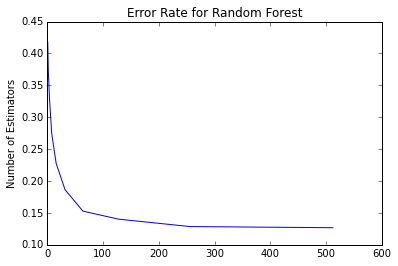

In [26]:
import time
import matplotlib.pyplot as plt
%matplotlib inline

errors = []
for n_estimators in 2**np.arange(10):
    tic = time.time()
    clf = sklearn.ensemble.RandomForestClassifier(n_estimators=n_estimators)
    clf.fit(train_values, train_labels)
    toc = time.time()
    pred = clf.predict(valid_values)
    error = 1 - np.average(valid_labels == pred)
    data = (n_estimators, toc-tic, 1-error)
    print("number of trees: %d, time to train: %f, accuracy: %f" % data)
    errors.append(error)
    
plt.plot(2**np.arange(10), errors)
plt.title('Error Rate for Random Forest')
plt.xlabel('Number of Estimators')
plt.ylabel('Error Rate')
plt.show()

In [47]:
n_estimators = 200

In [51]:
clf = sklearn.ensemble.RandomForestClassifier(n_estimators=n_estimators)
clf.fit(train_values, train_labels)
pred = clf.predict(valid_values)
print(np.average(valid_labels == pred))

0.87


What kind of errors are we making?

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


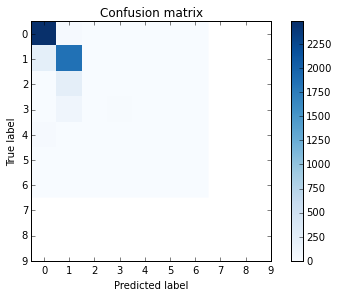

In [27]:
import sklearn.metrics
cm = sklearn.metrics.confusion_matrix(valid_labels, pred)

cmap=plt.cm.Blues
plt.figure()
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks)
plt.yticks(tick_marks)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [93]:
def label_freqs(labels):
    freqs = {}
    for label in labels:
        if label in freqs:
            freqs[label] += 1
        else:
            freqs[label] = 1
    return freqs
print("validation label frequency: {}".format(label_freqs(valid_labels)))
print("predicted label frequency: {}".format(label_freqs(pred)))

validation label frequency: {0: 2512, 1: 2093, 2: 239, 3: 120, 4: 20, 5: 9, 6: 7}
predicted label frequency: {0: 2666, 1: 2271, 2: 35, 3: 23, 5: 2, 7: 1, 8: 2}


Our classifier never predicts more than 3! 

What's more, our validation set includes no labels of 8 or 9.

In [109]:
clf = sklearn.ensemble.RandomForestClassifier(n_estimators=n_estimators, 
                                              max_features=0.5, 
                                              class_weight="balanced_subsample")
clf.fit(train_values, train_labels)
pred = clf.predict(valid_values)
print(np.average(valid_labels == pred))
print("predicted label frequency: {}".format(label_freqs(pred)))

0.9004
predicted label frequency: {0: 2684, 1: 2233, 2: 10, 3: 73}


In [107]:
test_df['Card1'] = (test_df['S1']-1) * 13 + (test_df['C1']) - 1
test_df['Card2'] = (test_df['S2']-1) * 13 + (test_df['C2']) - 1
test_df['Card3'] = (test_df['S3']-1) * 13 + (test_df['C3']) - 1
test_df['Card4'] = (test_df['S4']-1) * 13 + (test_df['C4']) - 1
test_df['Card5'] = (test_df['S5']-1) * 13 + (test_df['C5']) - 1
card_list = ['Card1','Card2','Card3','Card4','Card5']
test_card_df = test_df[card_list]
test_card_df = pd.get_dummies(test_card_df, prefix='Card', columns=card_list)
test_card_df = test_card_df.groupby(test_card_df.columns, axis=1).sum()

In [111]:
clf = sklearn.ensemble.RandomForestClassifier(n_estimators=n_estimators, 
                                              max_features=0.5, 
                                              class_weight="balanced_subsample")
clf.fit(card_df, train_df['hand'])
print('predicting')
pred = clf.predict(test_card_df)
print(label_freqs(pred))

predicting
{0: 527596, 1: 457030, 2: 2231, 3: 13004, 4: 56, 5: 44, 6: 33, 7: 3, 9: 3}
